Gráfico salvo em: ./Canada_0105-1505/PISOTEIO_unidade_Canada_periodo_0105-1505.png


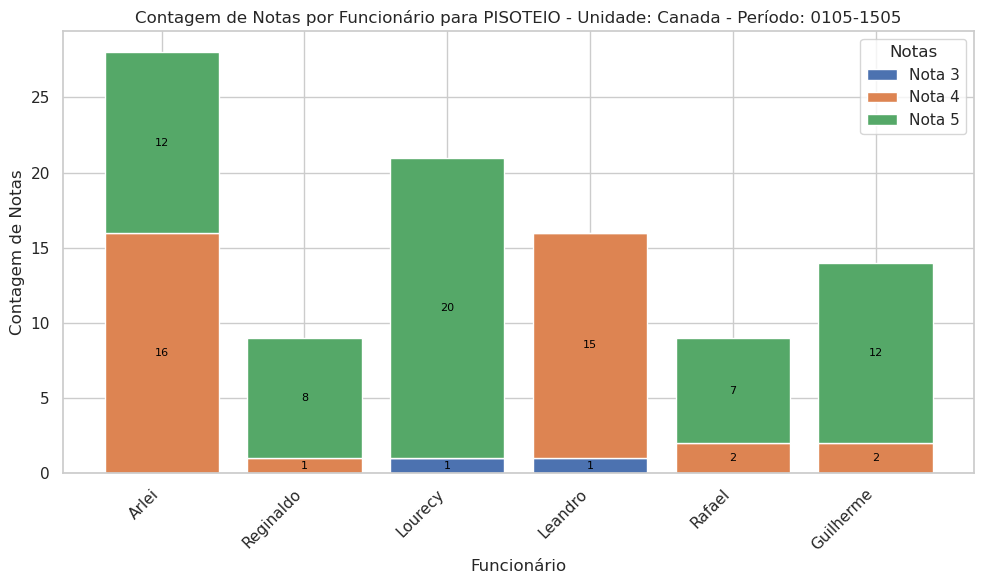

Gráfico salvo em: ./Canada_0105-1505/DANOS_unidade_Canada_periodo_0105-1505.png


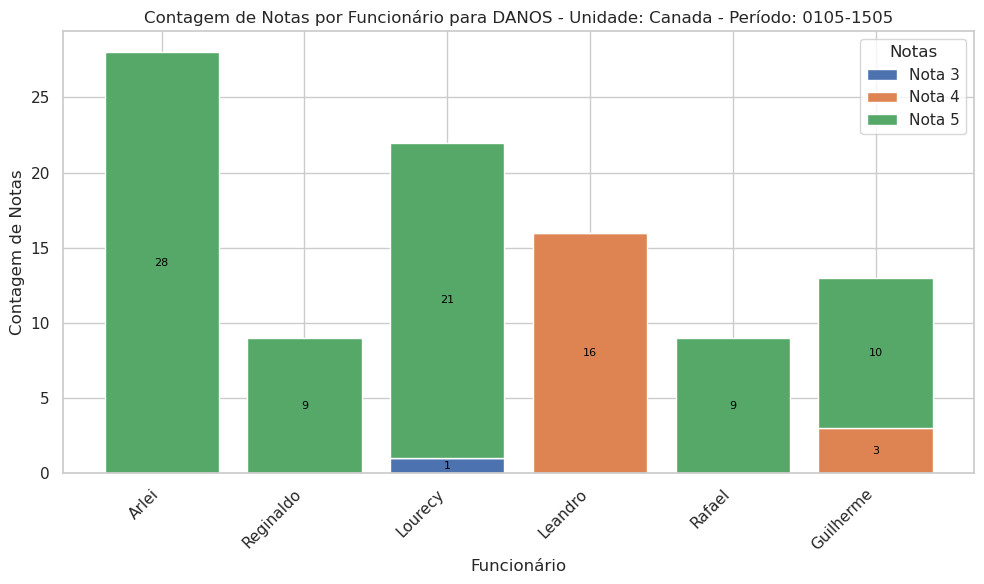

Gráfico salvo em: ./Canada_0105-1505/FOCO_unidade_Canada_periodo_0105-1505.png


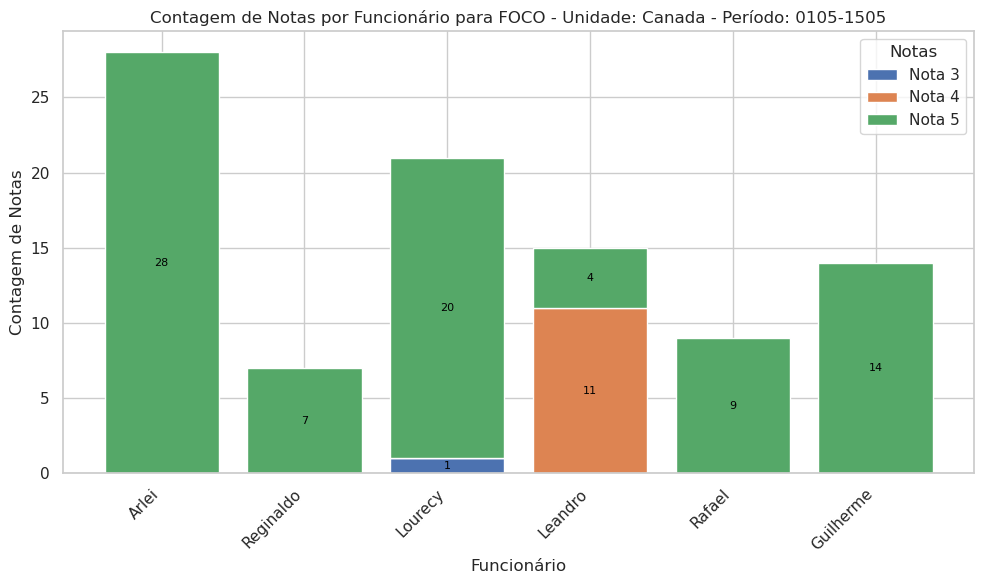

O gráfico foi salvo em: ./Canada_0105-1505/Variação dos indicadores - Canada - de 0105 a 1505.png
Cópia do arquivo de origem salva em: ./Canada_0105-1505/Canada_0105-1505.xlsx


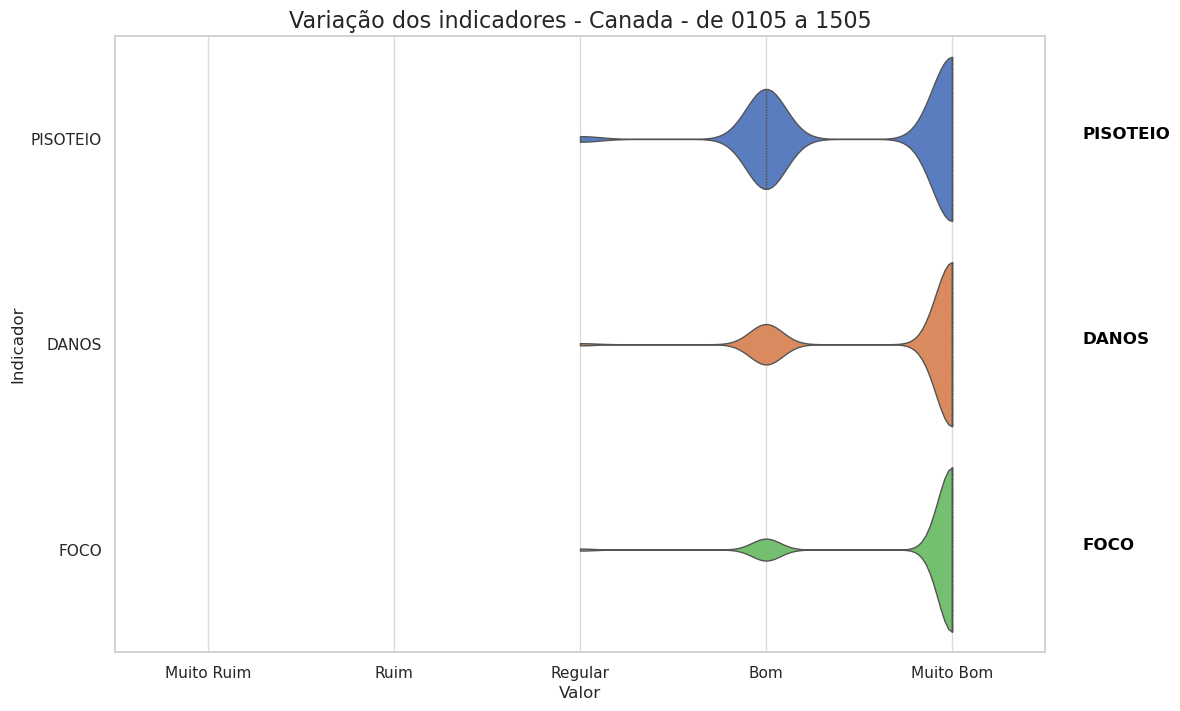

In [1]:
"""
Programa de Análise e Visualização de Indicadores de Colheita

Descrição:
Este programa realiza a análise e visualização de indicadores de desempenho da coheita de Cana de uma unidade, com base em dados coletados e armazenados em um arquivo CSV. As principais funcionalidades do programa incluem:

1. Carregamento e Pré-processamento de Dados:
   - Carrega os dados de um arquivo CSV.
   - Converte a coluna "Submit Date (UTC)" para o horário de Brasília e renomeia para "DATA E HORA DE REGISTRO".
   - Remove colunas desnecessárias e reordena as colunas para que "DATA E HORA DE REGISTRO" seja a primeira coluna.

2. Análise de Variáveis Específicas:
   - Gera gráficos de barras empilhadas para as variáveis específicas "PISOTEIO", "DANOS" e "FOCO".
   - Adiciona números sobre as barras indicando o total de registros por funcionário para cada nota específica.

3. Análise de Todas as Variáveis Numéricas:
   - Cria gráficos de violino para analisar a distribuição de todas as variáveis numéricas.

4. Exportação dos Resultados:
   - Salva os gráficos gerados em uma pasta nomeada de acordo com a unidade e o período especificados pelo usuário.
   - Salva uma cópia do arquivo CSV original no formato Excel, aplicando formatação condicional e alinhamento centralizado nas colunas "PISOTEIO", "DANOS" e "FOCO".
   - Aplica uma escala de cores de vermelho (mínimo) a verde (máximo) para as notas.

5. Configurações Adicionais:
   - Permite ao usuário especificar a unidade e o período de análise.
   - Adiciona filtros às colunas no arquivo Excel gerado.

Bibliotecas Utilizadas:
- pandas: Para manipulação de dados.
- matplotlib: Para criação de gráficos.
- seaborn: Para criação de gráficos de violino.
- openpyxl: Para manipulação e formatação de arquivos Excel.

Como Usar:
1. Certifique-se de ter o arquivo "responses.csv" no mesmo diretório do programa.
2. Execute o programa.
3. Insira a unidade e o período no formato DDMM-DDMM quando solicitado.
4. Os gráficos serão salvos na pasta de saída especificada e o arquivo Excel será gerado com as formatações aplicadas.

Possíveis melhorias para as proximas versões:
- Enviar os arquivos do console /saída por e-mail (conta Gmail: gapd.data.lab).Ver "monitor_colheita_email.md"
- Construir um dashboard usando plotly e dash
 obs.: as configurações para a próxima versão oferecer o dashboard interativo estão descritas no "monitor_colheita_melhorias.tx"

Autor: Roni Chittoni
Data: 17 de maio de 2024
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from openpyxl import load_workbook
from openpyxl.styles import Alignment
from openpyxl.formatting.rule import ColorScaleRule
from openpyxl.utils import get_column_letter

sns.set(style="whitegrid")

def main():
    file_path = 'responses.csv'
    
    # Perguntar ao usuário sobre a unidade e o período
    unidade = input("Digite a unidade: ")
    periodo = input("Digite o período (inicial e final no formato DDMM-DDMM): ")
    data_inicial, data_final = periodo.split('-')
    
    # Nome da pasta de saída
    output_folder = f'./{unidade}_{periodo}'
    
    data = load_data(file_path)
    
    # Converter a coluna de data "Submit Date (UTC)" para o formato horário de Brasília
    data = convert_utc_to_brasilia(data)
    
    # Analisar variáveis específicas com gráficos de barras empilhadas
    for variable in ['PISOTEIO', 'DANOS', 'FOCO']:
        create_stacked_count_chart(data, variable, output_folder, unidade, periodo)
    
    # Analisar todas as variáveis numéricas com gráficos de violino
    numeric_columns = ['PISOTEIO', 'DANOS', 'FOCO']
    data_numeric = filter_numeric_columns(data, numeric_columns)
    titulo = create_violin_plot(data_numeric, unidade, data_inicial, data_final)
    save_plot(titulo, output_folder)
    
    # Salvar uma cópia do arquivo de origem renomeada no formato Excel na mesma pasta dos gráficos
    save_copy_of_source_file_as_excel(data, output_folder, unidade, periodo)
    
    plt.show()

def load_data(file_path):
    return pd.read_csv(file_path)

def convert_utc_to_brasilia(data):
    if 'Submit Date (UTC)' in data.columns:
        data['Submit Date (UTC)'] = pd.to_datetime(data['Submit Date (UTC)'], utc=True)
        data['DATA E HORA DE REGISTRO'] = data['Submit Date (UTC)'].dt.tz_convert('America/Sao_Paulo').dt.strftime('%Y-%m-%d %H:%M:%S')
        data = data.drop(columns=['Submit Date (UTC)'])
        # Mover a coluna "DATA E HORA DE REGISTRO" para ser a primeira coluna
        cols = ['DATA E HORA DE REGISTRO'] + [col for col in data if col != 'DATA E HORA DE REGISTRO']
        data = data[cols]
    return data

def filter_numeric_columns(data, columns):
    return data[columns]

def create_stacked_count_chart(data, variable, output_folder, unidade, periodo):
    variable_data = data[['Seu nome', variable]].dropna(subset=['Seu nome'])
    scores = [3, 4, 5]
    employee_counts = pd.DataFrame(index=variable_data['Seu nome'].unique(), columns=scores).fillna(0)
    
    for employee in employee_counts.index:
        employee_scores = variable_data[variable_data['Seu nome'] == employee][variable]
        employee_counts.loc[employee, scores] = [employee_scores[employee_scores == score].count() for score in scores]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = np.zeros(len(employee_counts))
    for score in scores:
        bars = ax.bar(employee_counts.index, employee_counts[score], bottom=bottom, label=f'Nota {score}')
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f'{int(height)}',
                    ha='center',
                    va='center',
                    fontsize=8,
                    color='black'
                )
        bottom += employee_counts[score]
    
    ax.set_title(f'Contagem de Notas por Funcionário para {variable} - Unidade: {unidade} - Período: {periodo}')
    ax.set_xlabel('Funcionário')
    ax.set_ylabel('Contagem de Notas')
    ax.legend(title='Notas')
    plt.xticks(rotation=45, ha='right')
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    file_name = f'{variable}_unidade_{unidade}_periodo_{periodo}.png'
    file_path = os.path.join(output_folder, file_name)
    plt.savefig(file_path)
    plt.tight_layout()
    print(f'Gráfico salvo em: {file_path}')
    plt.show()

def create_violin_plot(data, unidade, data_inicial, data_final):
    plt.figure(figsize=(12, 8))
    
    melted_data = data.melt(var_name='Indicador', value_name='Valor')
    sns.violinplot(x='Valor', y='Indicador', data=melted_data, bw_adjust=0.5, inner='quartile', cut=0, linewidth=1, palette="muted", hue='Indicador', dodge=False, legend=False)
    
    plt.xlim(0.5, 5.5)
    plt.xticks([1, 2, 3, 4, 5], ['Muito Ruim', 'Ruim', 'Regular', 'Bom', 'Muito Bom'])
    plt.grid(axis='x', linestyle='-', alpha=0.7)
    
    for line in range(len(melted_data['Indicador'].unique())):
        plt.text(5.7, line, melted_data['Indicador'].unique()[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    
    titulo = f'Variação dos indicadores - {unidade.title()} - de {data_inicial} a {data_final}'
    plt.title(titulo, fontsize=16)
    return titulo

def save_plot(titulo, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    file_name = f'{titulo}.png'
    file_path = os.path.join(output_folder, file_name)
    plt.savefig(file_path)
    print(f'O gráfico foi salvo em: {file_path}')

def apply_conditional_formatting(worksheet, columns):
    # Define a regra de formatação condicional
    color_scale_rule = ColorScaleRule(
        start_type='min', start_color='FF0000',
        mid_type='percentile', mid_value=50, mid_color='FFFF00',
        end_type='max', end_color='00FF00'
    )
    # Aplica a regra de formatação condicional nas colunas especificadas
    for col_letter in columns:
        col_range = f'{col_letter}2:{col_letter}{worksheet.max_row}'
        worksheet.conditional_formatting.add(col_range, color_scale_rule)
        # Aplica o alinhamento centralizado
        for cell in worksheet[col_range]:
            for c in cell:
                c.alignment = Alignment(horizontal='center')

def save_copy_of_source_file_as_excel(data, output_folder, unidade, periodo):
    # Excluir as colunas especificadas pelos rótulos
    columns_to_drop = ['#', 'Response Type', 'Start Date (UTC)', 'Stage Date (UTC)', 'Network ID', 'Tags']
    data = data.drop(columns=columns_to_drop, errors='ignore')  # errors='ignore' to skip if column not found
    
    # Criação do nome do arquivo de cópia
    base_name = f'{unidade}_{periodo}'
    new_file_path = os.path.join(output_folder, f'{base_name}.xlsx')
    
    # Verifica se a pasta de saída existe e cria se necessário
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Salva o DataFrame no formato Excel com filtros
    with pd.ExcelWriter(new_file_path, engine='openpyxl') as writer:
        data.to_excel(writer, index=False, sheet_name='Sheet1')
        workbook  = writer.book
        worksheet = writer.sheets['Sheet1']
        # Adiciona filtros
        worksheet.auto_filter.ref = worksheet.dimensions
    
    # Reabrir o arquivo para aplicar formatação condicional
    wb = load_workbook(new_file_path)
    ws = wb.active
    # Encontrar as letras das colunas para PISOTEIO, DANOS e FOCO
    columns = ['PISOTEIO', 'DANOS', 'FOCO']
    column_letters = [get_column_letter(data.columns.get_loc(col) + 1) for col in columns]
    apply_conditional_formatting(ws, column_letters)
    wb.save(new_file_path)
    
    print(f'Cópia do arquivo de origem salva em: {new_file_path}')

if __name__ == "__main__":
    main()